In [1]:
# Code used to create the results in section 2.7 of the paper 
# "Analysis and Comparison of Classification Metrics" 

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
from scipy.special import expit, logit
import sys
sys.path += ["../../", "../"]
from expected_cost import ec, utils



Generate a family of confusion matrices, compute different metrics from it, and plot their comparisons

In [2]:
outdir = "outputs/Metrics_over_hard_decisions"
utils.mkdir_p(outdir)

# Total number of samples to generate
K  = 1000

# Number of samples for class 1. In the paper, this is called R2*. 
# For the balanced case, it should be set to 500, for the imbalanced 
# set, to 100.
N1 = 500

# Number of samples for class 0. In the paper, this is R1*.
N0 = K-N1

# We consider two priors, the ones in the data and the uniform one
priors_data = np.array([N0/K, N1/K])
priors_unif = np.array([0.5, 0.5])

# We consider to cost matrices, the usual 0-1 matrix
# and one with a higher weight for K10
costs_01 = ec.CostMatrix([[0, 1], [1, 0]])
costs_0b = ec.CostMatrix([[0, 1], [2, 0]])

# Output dir
out_name = "%s/results_for_prior1_%.2f"%(outdir,N1/K)
print("Dumping plots in %s*"%out_name)


Dumping plots in outputs/Metrics_over_hard_decisions/results_for_prior1_0.50*


K10    K01  |     NEC_u    NEC_b^2=1   NEC_b^2=2   F_b=1       MCC   |   R21     R12   |   R*2    R*1
   0     50 |      0.10       0.10       0.10       0.95       0.90  |   0.00    0.10  |   0.55   0.45
   0    250 |      0.50       0.50       0.50       0.80       0.58  |   0.00    0.50  |   0.75   0.25
   0    450 |      0.90       0.90       0.90       0.69       0.23  |   0.00    0.90  |   0.95   0.05
  25     25 |      0.10       0.10       0.15       0.95       0.90  |   0.05    0.05  |   0.50   0.50
  25    225 |      0.50       0.50       0.55       0.79       0.55  |   0.05    0.45  |   0.70   0.30
  50      0 |      0.10       0.10       0.20       0.95       0.90  |   0.10    0.00  |   0.45   0.55
 125    125 |      0.50       0.50       0.75       0.75       0.50  |   0.25    0.25  |   0.50   0.50
 225    225 |      0.90       0.90       1.35       0.55       0.10  |   0.45    0.45  |   0.50   0.50
 250      0 |      0.50       0.50       1.00       0.67       0.58  |   0

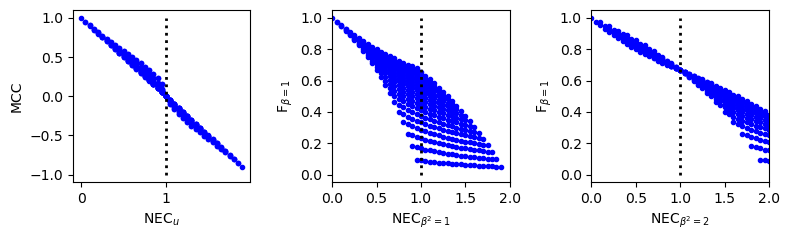

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,2.5))

print("K10    K01  |     NEC_u    NEC_b^2=1   NEC_b^2=2   F_b=1       MCC   |   R21     R12   |   R*2    R*1")

# K10: number of class 1 samples labelled as 0
for K10 in np.arange(0,N1,int(N1/20)):

    EC1s = []
    EC2s = []
    EC3s = []
    FSs  = []
    MCCs = []

    # K01: number of class 0 samples labelled as 1
    for K01 in np.arange(0,N0,int(N0/20)):

        # Get the normalized confusion matrix needed to compute the metrics
        R = utils.compute_R_matrix_from_counts_for_binary_classif(K01, K10, N0, N1)

        # Compute various metrics based on the confusion matrix
        EC1s.append(ec.average_cost_from_confusion_matrix(R, priors_unif, costs_01, adjusted=True))
        EC2s.append(ec.average_cost_from_confusion_matrix(R, priors_data, costs_01, adjusted=True))
        EC3s.append(ec.average_cost_from_confusion_matrix(R, priors_data, costs_0b, adjusted=True))
        FSs.append(utils.Fscore(K10, K01, N0, N1))
        MCCs.append(utils.MCCoeff(K10, K01, N0, N1))

        # Print results
        if (K10==0 or K01==0 or K10==K01 or np.abs(K01-10*K10)<100) and np.around(EC1s[-1],1) in [0.1,0.5,0.9]:
            print("%4d   %4d | %9.2f  %9.2f  %9.2f  %9.2f  %9.2f  |  %5.2f   %5.2f  |  %5.2f  %5.2f"%
                 (K10, K01, EC1s[-1], EC2s[-1], EC3s[-1], FSs[-1], MCCs[-1], K10/N1, K01/N0, (N1-K10+K01)/K, (N0-K01+K10)/K))

    # Plot three scatter plots
    ax1.plot(EC1s, MCCs, 'b.', label="K10=%d"%K10)
    ax2.plot(EC2s, FSs,  'b.', label="K10=%d"%K10)
    ax3.plot(EC3s, FSs,  'b.', label="K10=%d"%K10)

# Add labels and limits to the plots
ax1.set_xlabel(r'$\mathrm{NEC}_u$')
ax1.set_ylabel("MCC")
ax1.plot([1,1],[-1,1],'k:',linewidth=2)

ax2.set_xlabel(r'$\mathrm{NEC}_{\beta^2=1}$')
ax2.set_ylabel(r'$\mathrm{F}_{\beta=1}$')
ax2.set_xlim(0,2)
ax2.plot([1,1],[0,1],'k:',linewidth=2)

ax3.set_xlabel(r'$\mathrm{NEC}_{\beta^2=2}$')
ax3.set_ylabel(r'$\mathrm{F}_{\beta=1}$')
ax3.set_xlim(0,2)
ax3.plot([1,1],[0,1],'k:',linewidth=2)

fig.tight_layout()
fig.savefig(out_name+".pdf")